In [915]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from functools import reduce
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
import lightgbm as lgb
# from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge  # мета-модель
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [916]:
train_xlsx = pd.read_excel("data/train.xlsx").to_csv("csvs/train.csv", sep=",", index = False)
test_xlsx = pd.read_excel("data/test.xlsx").to_csv("csvs/test.csv", sep=",", index = False)
gruz = pd.read_excel("data/Грузоперевозки.xlsx").to_csv("csvs/cargo.csv", sep=",", index = False)
rynok_data = pd.read_excel("data/Данные рынка стройматериалов.xlsx").to_csv("csvs/market_data.csv", sep=",", index = False)
lme = pd.read_excel("data/Индекс LME.xlsx").to_csv("csvs/index_LME.csv",sep=",", index = False)
macro_pok = pd.read_excel("data/Макропоказатели.xlsx").to_csv("csvs/macro.csv", sep=",", index = False)
pok_ryn = pd.read_excel("data/Показатели рынка металла.xlsx").to_csv("csvs/metal_market.csv", sep=",", index = False)
topl = pd.read_excel("data/Топливо.xlsx").to_csv("csvs/fuel.csv", sep=",", index = False)
syrye_price = pd.read_excel("data/Цены на сырье.xlsx").to_csv("csvs/material_price.csv", sep=",", index = False)

train = pd.read_csv("csvs/train.csv")
test = pd.read_csv("csvs/test.csv")

train = pd.concat([train, test])

cargo = pd.read_csv("csvs/cargo.csv")
market_data = pd.read_csv("csvs/market_data.csv")
index_LME = pd.read_csv("csvs/index_LME.csv")
macro = pd.read_csv("csvs/macro.csv")
metal_market = pd.read_csv("csvs/metal_market.csv")
fuel = pd.read_csv("csvs/fuel.csv")
material_price = pd.read_csv("csvs/material_price.csv")

In [917]:
index_LME['цена'] = pd.to_numeric(index_LME['цена'], errors='coerce')
index_LME.dropna()
index_LME['цена'] = index_LME['цена'].dropna().astype(float)
index_LME.rename(columns={'дата': 'dt'}, inplace=True) 

add_data = [
    train,
    cargo,
    market_data,
    index_LME,
    macro,
    metal_market,
    fuel,
    material_price
]

In [918]:
for i, data in enumerate(add_data):
    data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')
    add_data[i] = data.set_index('dt').resample('W-MON').mean().reset_index()
    print(f"{data['dt'].min()} - {data['dt'].max()}")
    
data['dt'] = data['dt'].dt.date

2015-01-05 00:00:00 - 2023-03-13 00:00:00
2017-09-06 00:00:00 - 2023-06-14 00:00:00
2021-04-30 00:00:00 - 2023-04-30 00:00:00
2021-02-12 00:00:00 - 2023-03-27 00:00:00
2016-01-31 00:00:00 - 2023-06-16 00:00:00
2016-03-31 00:00:00 - 2023-03-31 00:00:00
2017-02-28 00:00:00 - 2023-05-31 00:00:00
2015-02-09 00:00:00 - 2023-03-13 00:00:00


In [919]:
min_date = max(data['dt'].min() for data in add_data)
max_date = min(data['dt'].max() for data in add_data)
print(min_date, '  ------------  ', max_date)

2021-05-03 00:00:00   ------------   2023-03-13 00:00:00


In [920]:
for data in add_data:
    data = data[(data['dt'] >= min_date) & (data['dt'] <= max_date)].reset_index(drop=True)
train = train.set_index('dt')

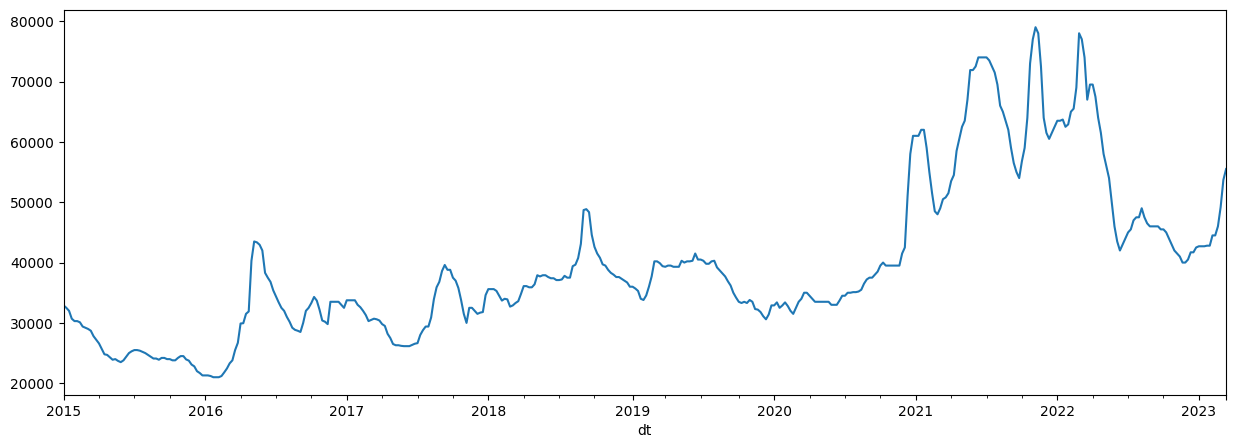

In [921]:
train['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

<Axes: title={'center': 'Остаток'}, xlabel='dt'>

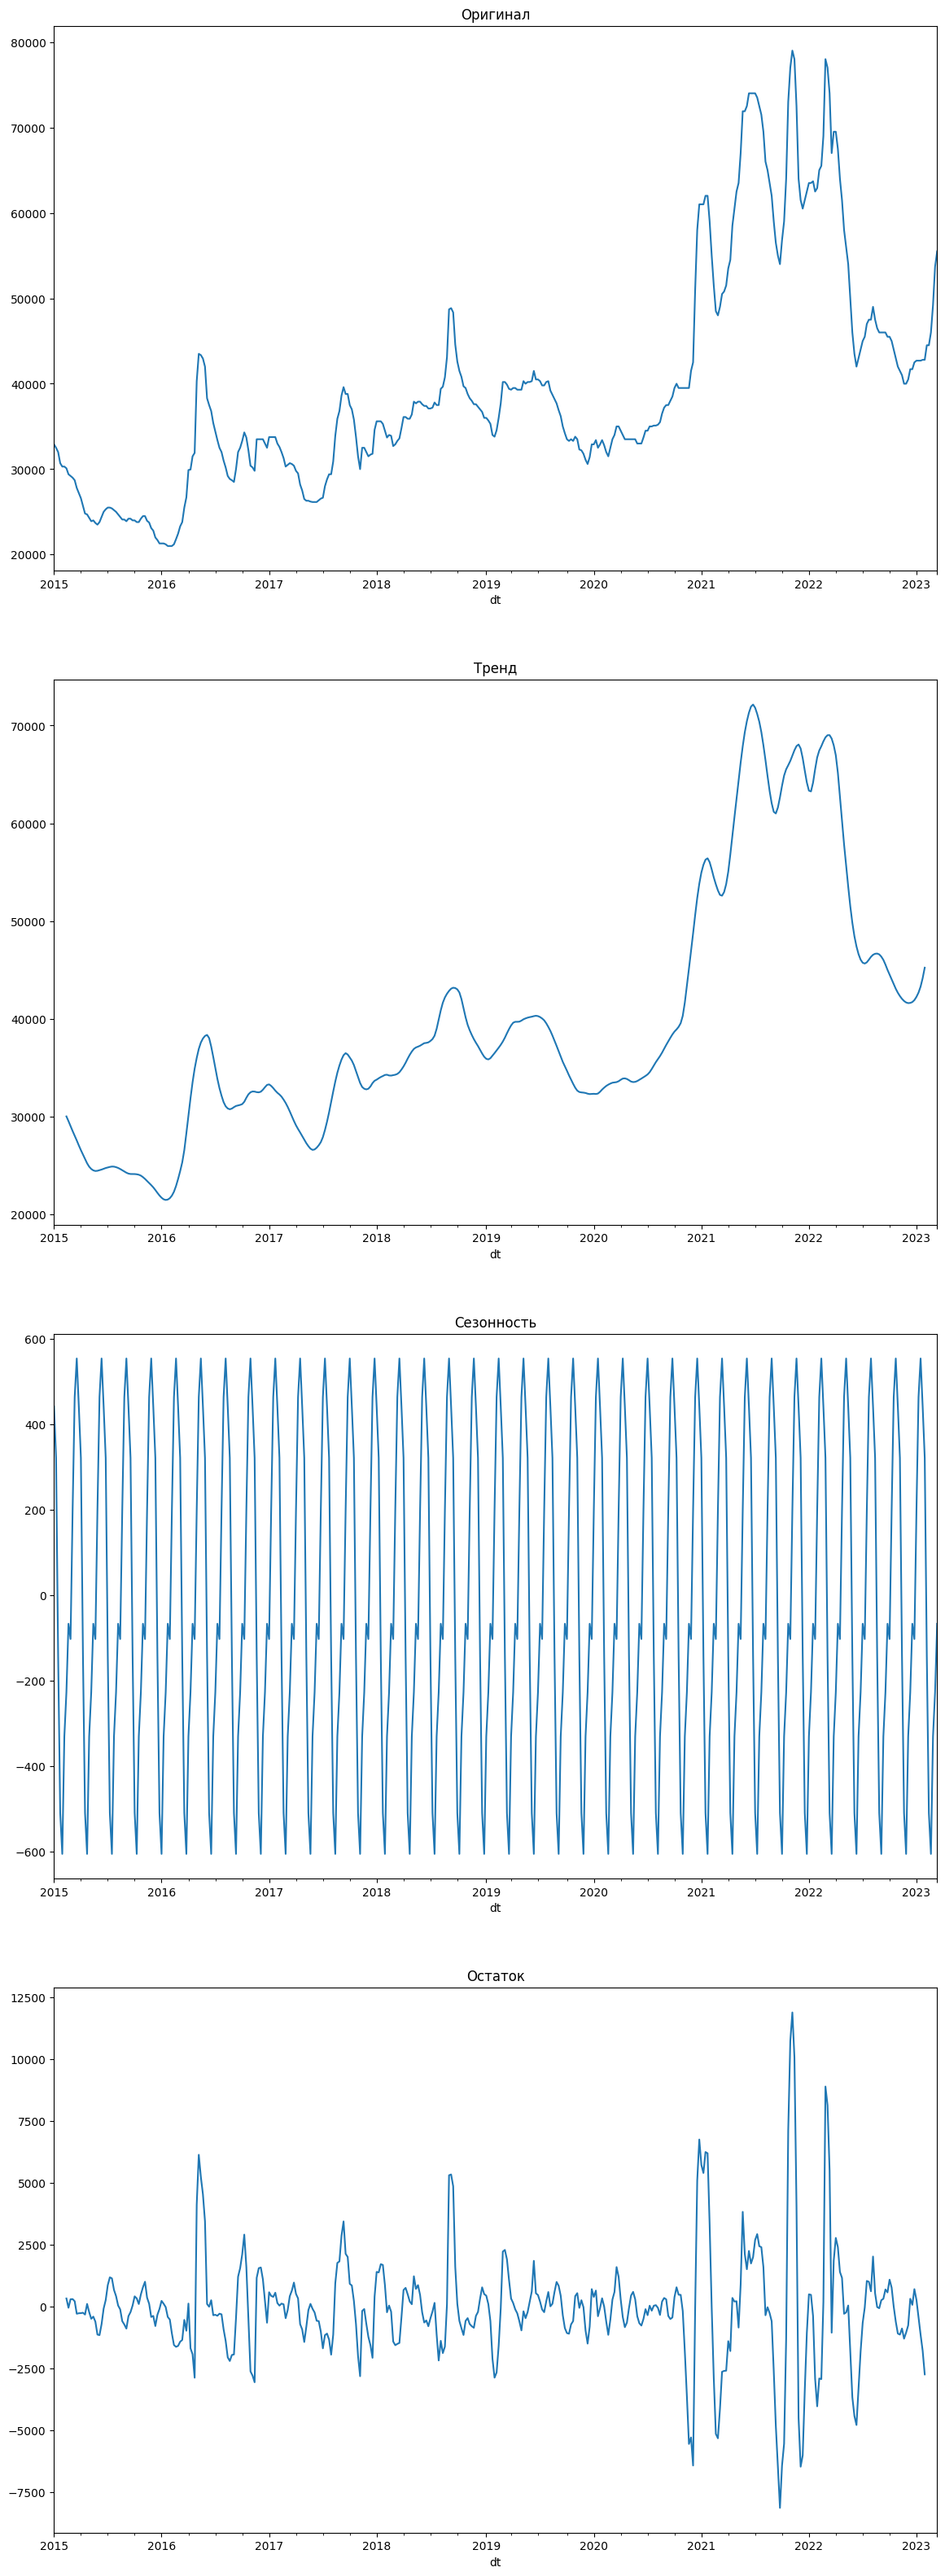

In [922]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(train['Цена на арматуру'], period=12)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Остаток')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

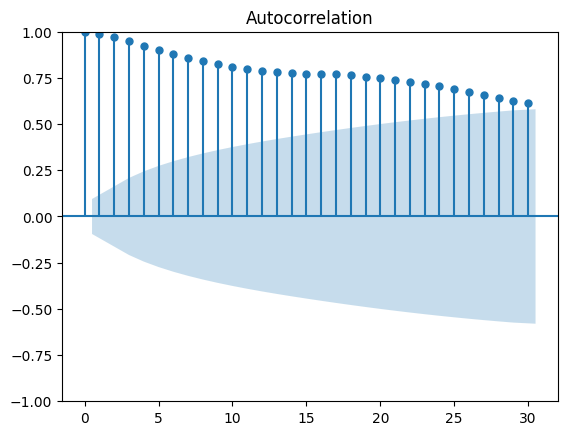

In [923]:
plot_acf(train['Цена на арматуру'], lags=30)  
plt.show()


In [924]:

df_merged = reduce(lambda left, right: pd.merge(left, right, on='dt', how='inner'), add_data)  # заполнить маркет дата на 4 недели чтобы без выебонов
df_merged.set_index('dt', inplace=True)
df_merged.index = df_merged.index.date
df_merged.index = pd.to_datetime(df_merged.index)

df_merged.to_csv('df_merged1.csv')
df_merged.head()

Цена на арматуру  Индекс стоимости грузоперевозок  \
2021-05-03           62500.0                           1060.0   
2021-05-10           63500.0                           1094.0   
2021-05-17           67000.0                           1073.0   
2021-05-24           71900.0                           1078.0   
2021-05-31           71900.0                           1096.0   

            Импорт цемента ЖД  Экспорт цемента ЖД  Отгрузка цемента хоппер ЖД  \
2021-05-03             40.751              27.530                     987.540   
2021-05-10                NaN                 NaN                         NaN   
2021-05-17                NaN                 NaN                         NaN   
2021-05-24                NaN                 NaN                         NaN   
2021-05-31             69.979              43.423                    1071.832   

            Отгрузка цемента остальные ЖД  Производство цемента  \
2021-05-03                        201.757                2.3891   
2021-05-10                            NaN                   NaN   
2021-05-17                            NaN                   NaN   
2021-05-24                            NaN                   NaN   
2021-05-31                        256.733                2.7115   

            Импорт цемента  Экспорт цемента  Потребление цемента  ...  \
2021-05-03       52.331737         31.49115             2.290941  ...   
2021-05-10             NaN              NaN                  NaN  ...   
2021-05-17             NaN              NaN                  NaN  ...   
2021-05-24             NaN              NaN                  NaN  ...   
2021-05-31       79.639340         50.16415             2.670775  ...   

            Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС  \
2021-05-03                                                NaN      
2021-05-10                                                NaN      
2021-05-17                                                NaN      
2021-05-24                                                NaN      
2021-05-31                                                NaN      

            Чугун_CFR Турция, $/т  \
2021-05-03                  590.0   
2021-05-10                  613.5   
2021-05-17                  665.0   
2021-05-24                  670.0   
2021-05-31                  667.5   

            ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС  \
2021-05-03                                            12736.0                           
2021-05-10                                            12736.0                           
2021-05-17                                            12736.0                           
2021-05-24                                            12736.0                           
2021-05-31                                            13956.0                           

            ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС  \
2021-05-03                                            10537.0                            
2021-05-10                                            10537.0                            
2021-05-17                                            10537.0                            
2021-05-24                                            10537.0                            
2021-05-31                                            10279.0                            

            ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС  \
2021-05-03                                             4439.0                          
2021-05-10                                             4439.0                          
2021-05-17                                             4439.0                          
2021-05-24                                             4439.0                          
2021-05-31                                             4420.0                          

            ЖРС_Средневзвешенная цена за 1 % Fe в аглор

In [925]:
df_cleaned = df_merged.dropna(axis=1, how='all')
df_cleaned.interpolate(method='linear', inplace=True)

print(df_cleaned.isnull().sum().sum())

1124


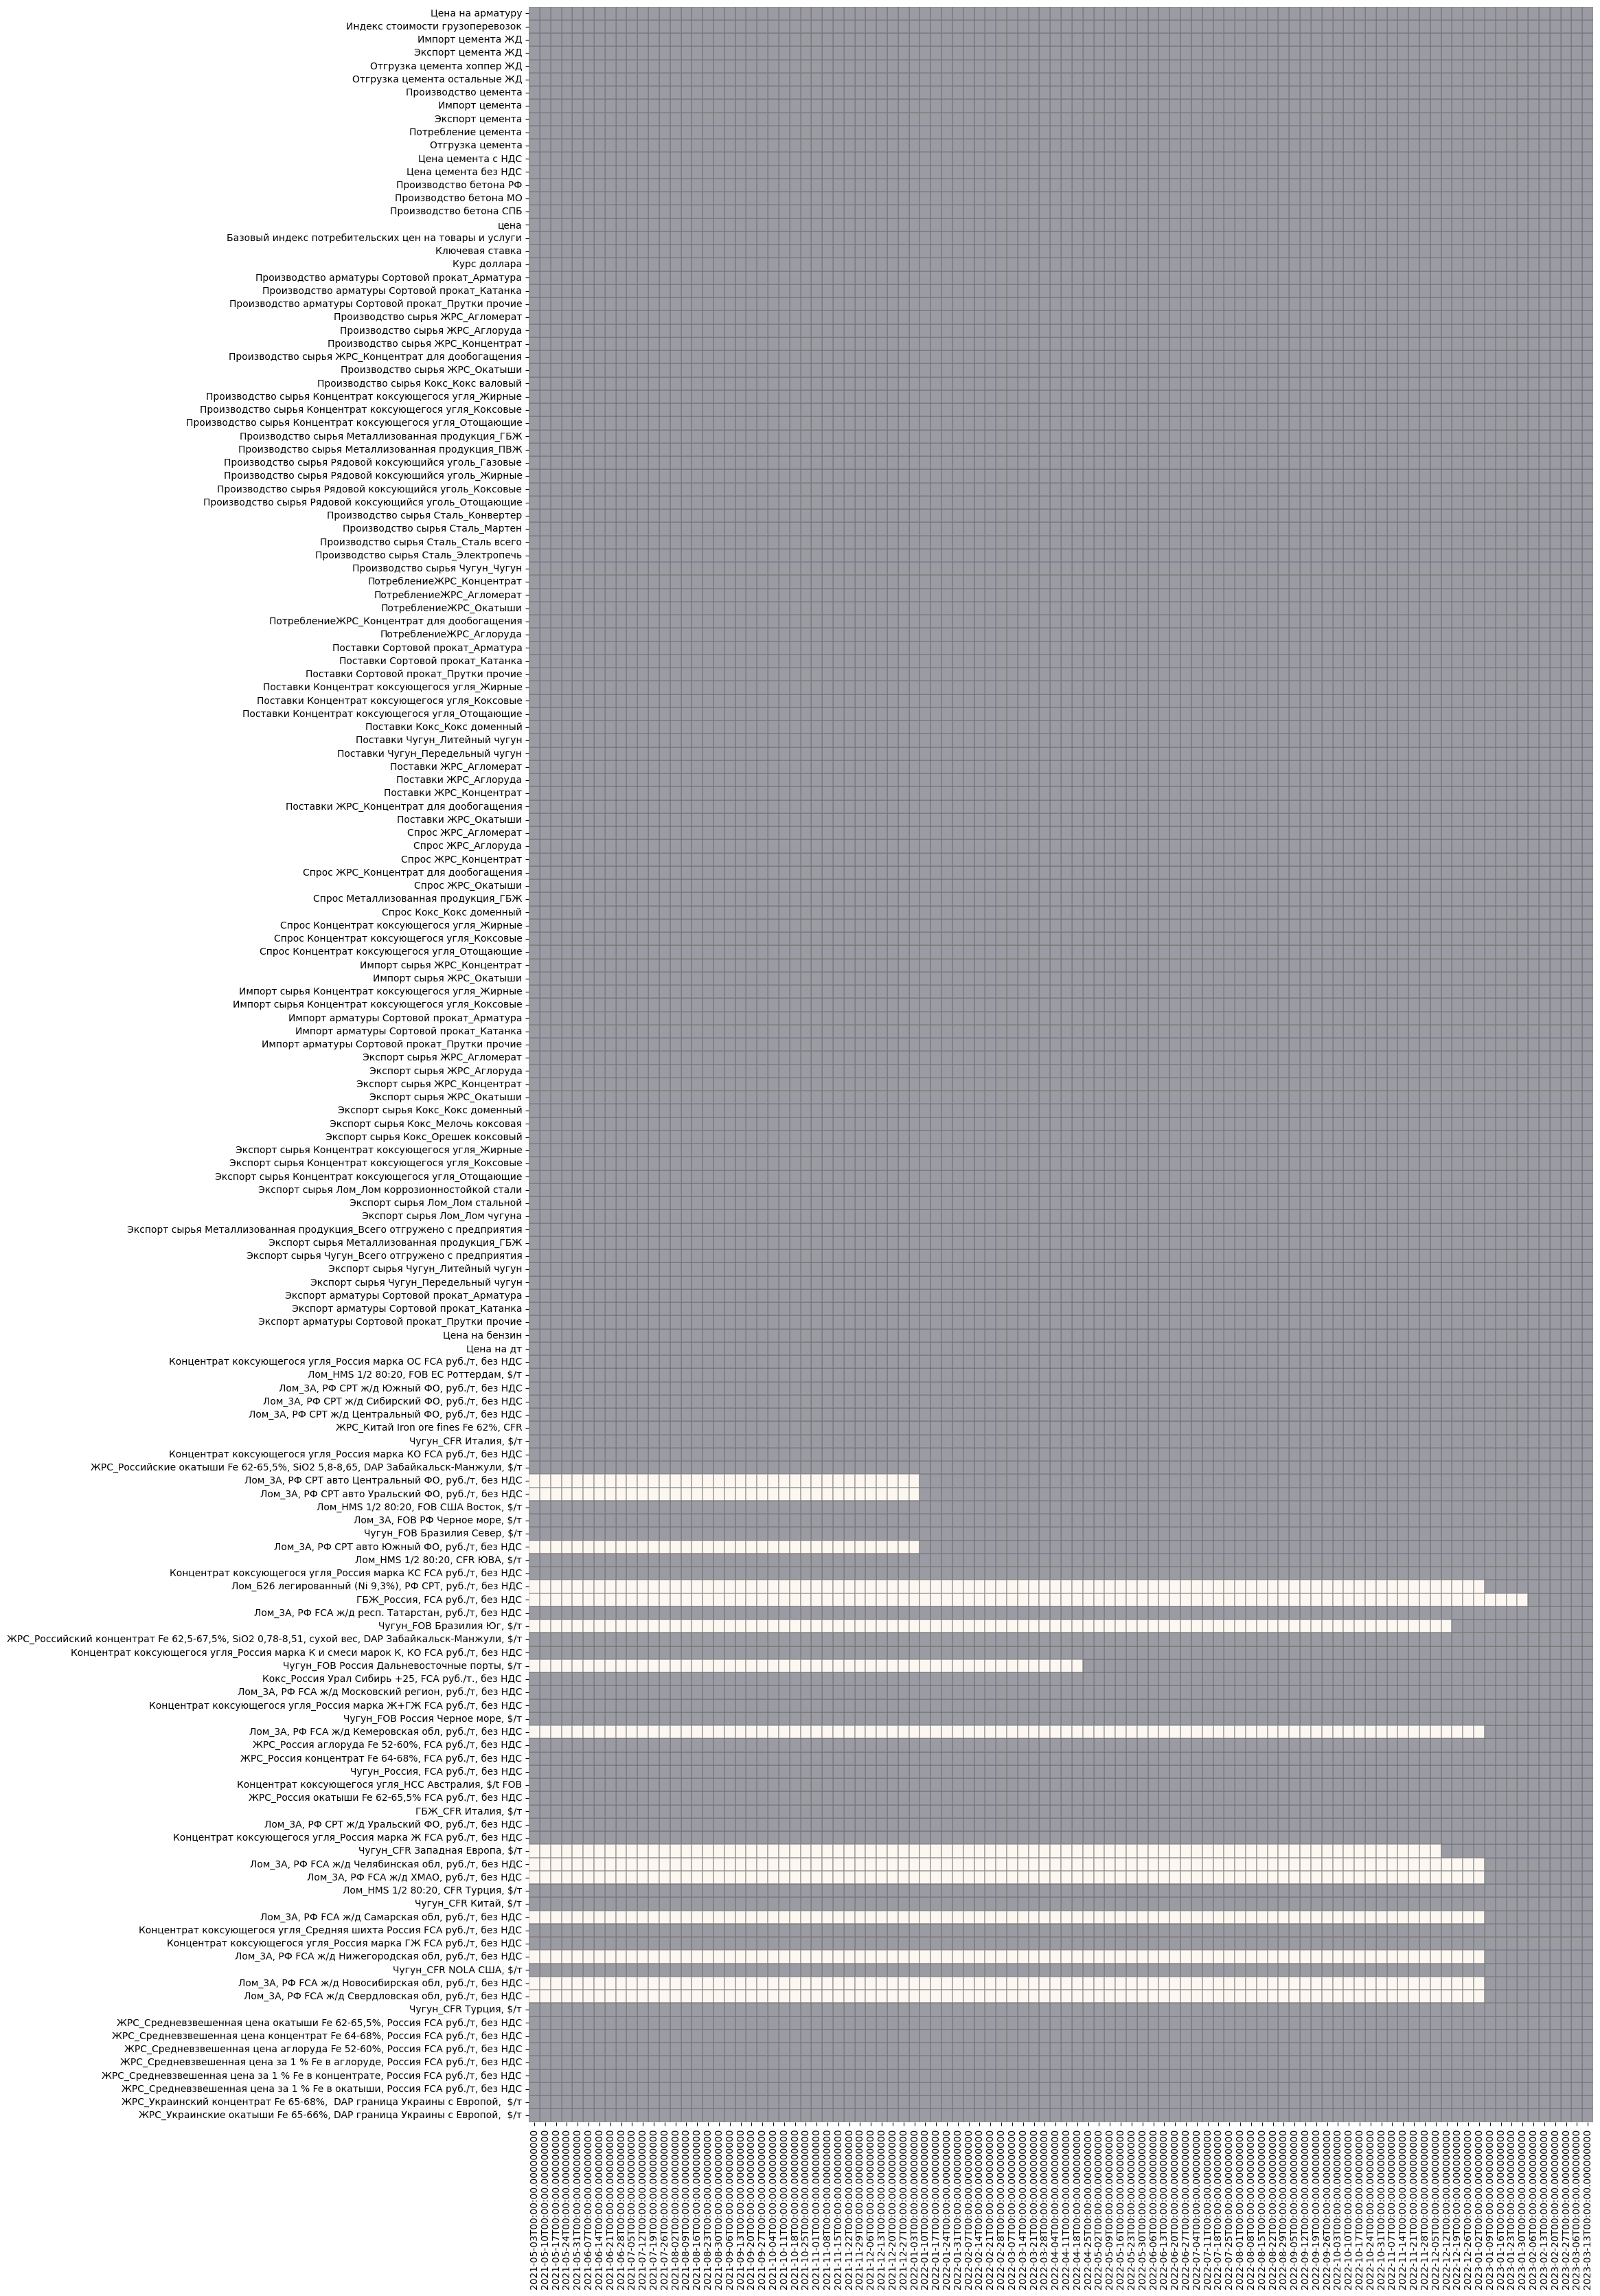

In [926]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

In [927]:
df_cleaned.dropna(axis=1, inplace=True)

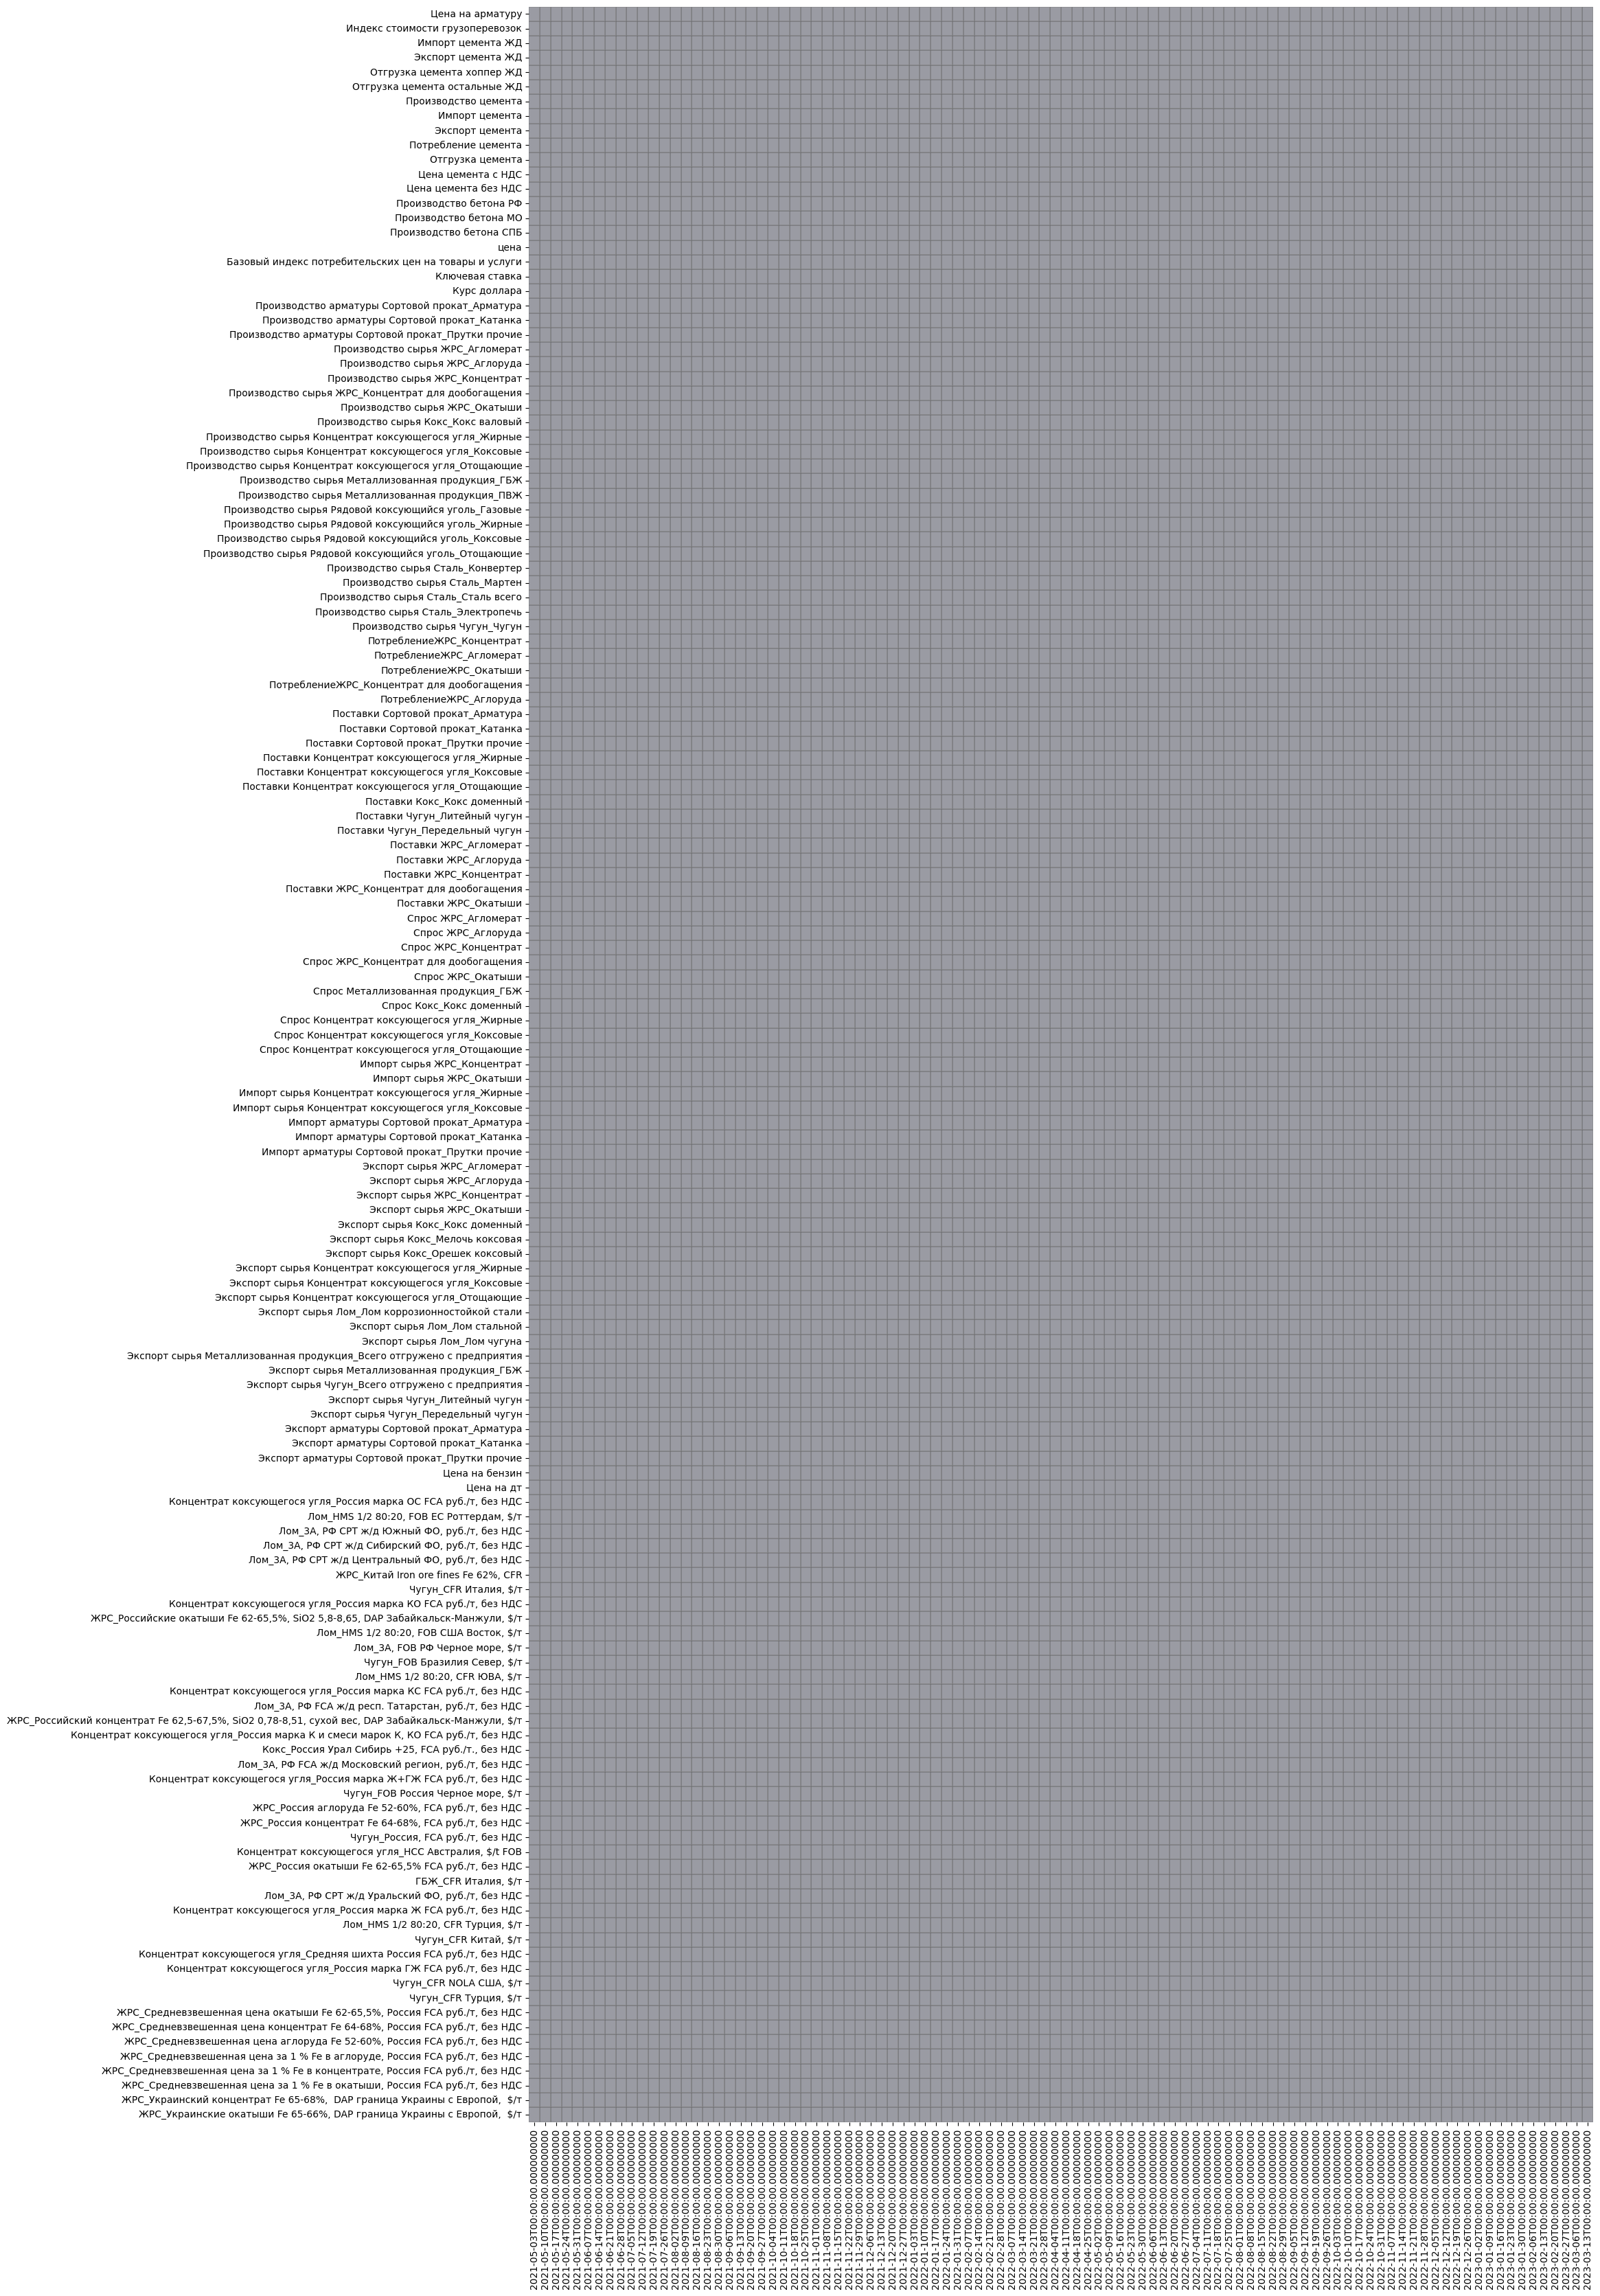

In [928]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T.isnull(), cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

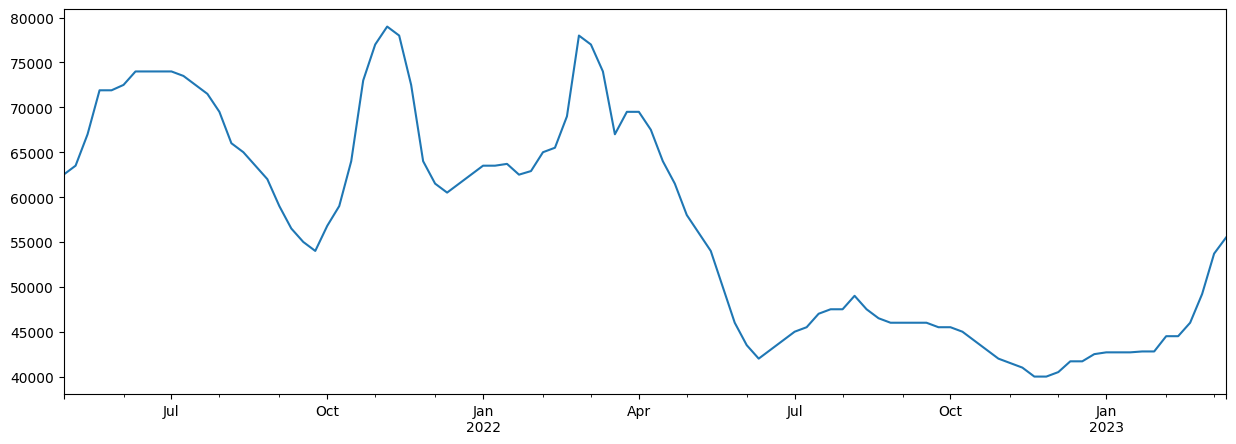

In [929]:
df_cleaned['Цена на арматуру'].plot(figsize=(15, 5))
plt.show()

In [930]:
# def number_encode_features(init_df):
#     result = init_df.copy()
#     encoders = {}
#     for column in result.columns:
#         if result.dtypes[column] == object:
#             encoders[column] = LabelEncoder()
#             result[column] = encoders[column].fit_transform(result[column])      # нужна она блять или нет
#     return result, column

# encoded_df, encoders = number_encode_features(df_cleaned)
# corr_mat = encoded_df.corr()

# plt.figure(figsize=[70, 70])
# sns.heatmap(corr_mat, annot=True)
# plt.show()

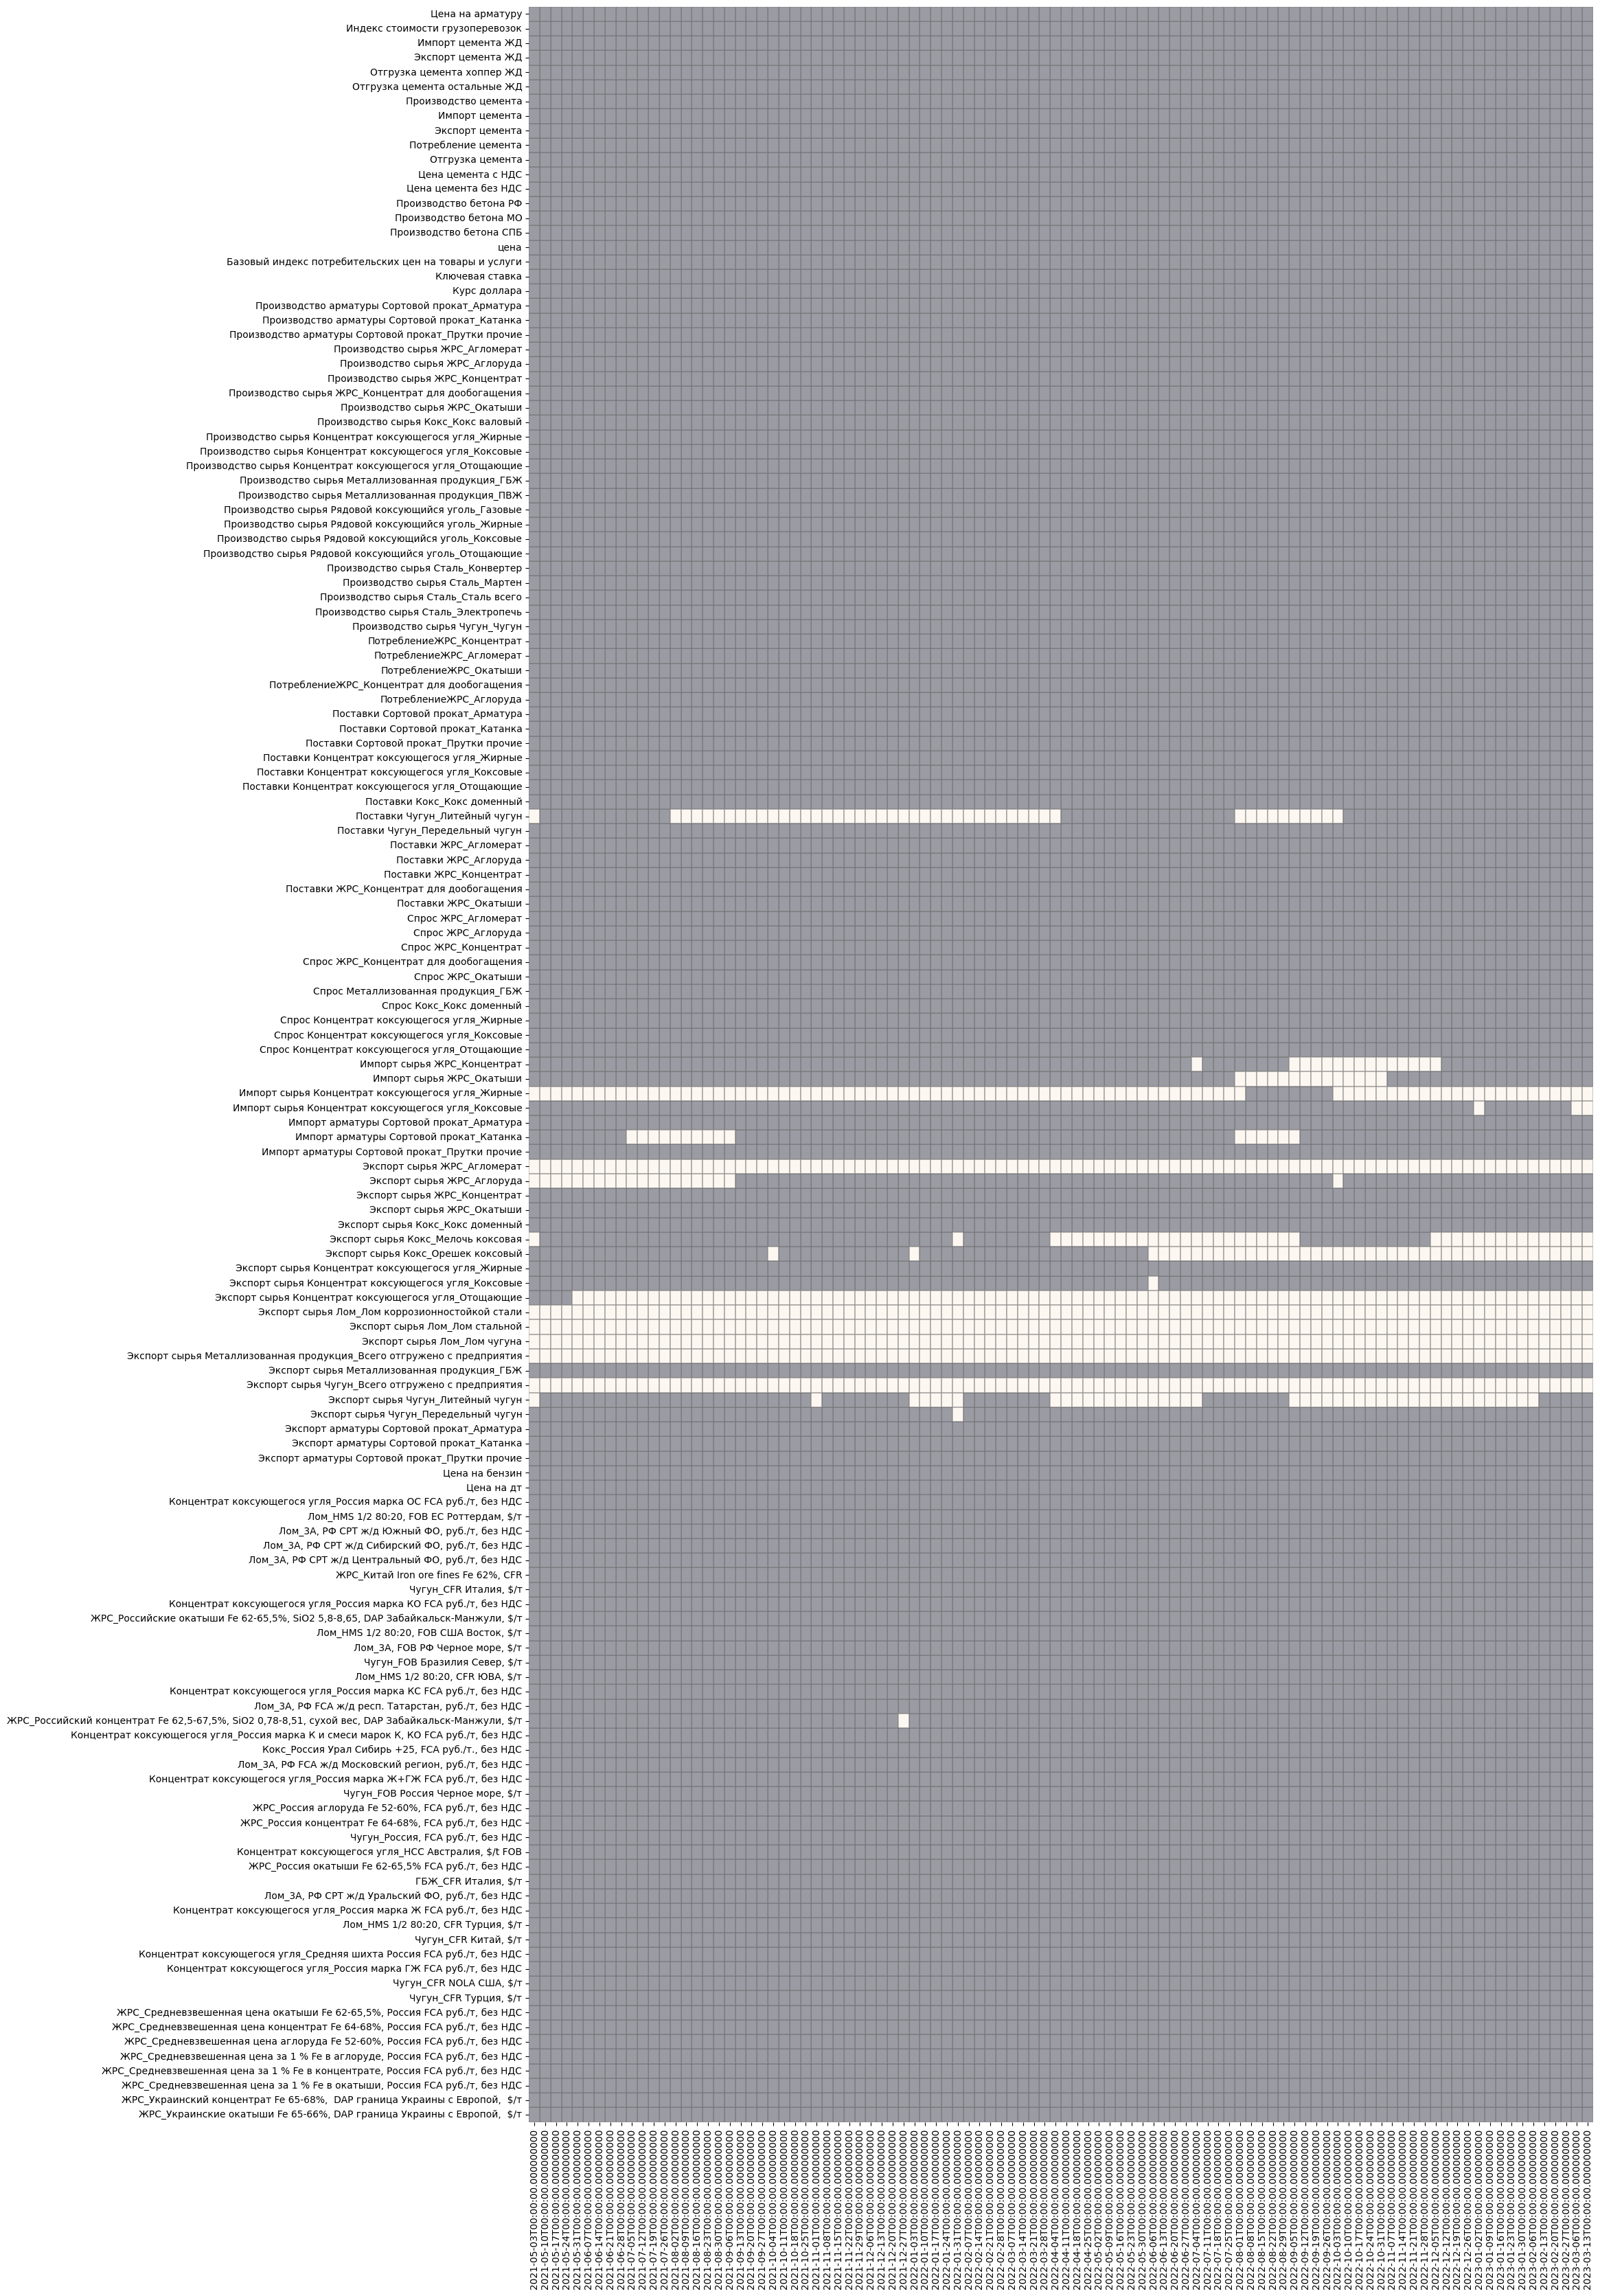

In [931]:
plt.figure(figsize=(20, 40)) 
sns.heatmap(df_cleaned.T==0, cbar=False, linewidths=0.1, linecolor='gray', alpha=0.4)
plt.show()

In [932]:
df_cleaned = df_cleaned.loc[:, (df_cleaned == 0.0).mean() <= 0.8]

In [933]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

check_stationarity(df_cleaned['Цена на арматуру'])  # Проверь целевую переменную

ADF Statistic: -2.1271051502672043
p-value: 0.23375606345581706
Critical Value (1%): -3.5003788874873405
Critical Value (5%): -2.8921519665075235
Critical Value (10%): -2.5830997960069446


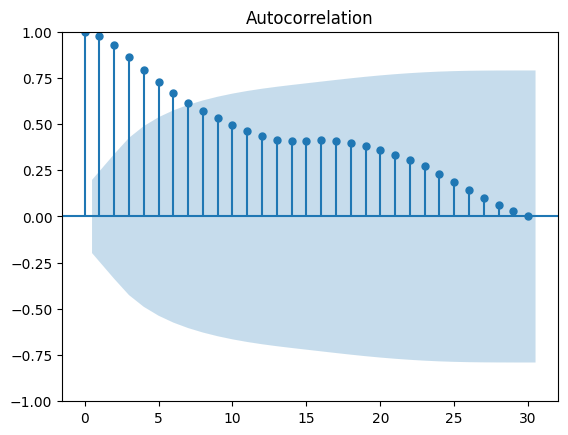

In [934]:
plot_acf(df_cleaned['Цена на арматуру'], lags=30)  # Смотрим автокорреляцию на 30 лагов
plt.show()

In [935]:
df_cleaned = df_cleaned.rename(columns={'Цена на арматуру':'price'})

df_cleaned['price_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(1)
df_cleaned['price_seasonal_diff'] = df_cleaned['price'] - df_cleaned['price'].shift(12)
df_cleaned.dropna(inplace=True)  # Убираем NaN в начале

check_stationarity(df_cleaned['price_diff'])  # Тест на стационарность

ADF Statistic: -4.6274311396714625
p-value: 0.00011493858964109401
Critical Value (1%): -3.5097356063504983
Critical Value (5%): -2.8961947486260944
Critical Value (10%): -2.5852576124567475


In [936]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.08, random_state=42)


from sklearn.model_selection import KFold

# KFold вместо TimeSeriesSplit
kf = KFold(n_splits=5, shuffle=False)

# Создаём стекинг-регрессор
stacking_model = StackingCVRegressor(
    regressors=[
        xgb.XGBRegressor(n_estimators=700, learning_rate=0.04, random_state=42),
        lgb.LGBMRegressor(n_estimators=700, learning_rate=0.04, random_state=42)], 
        meta_regressor=Ridge(alpha=1.0), cv=3, random_state=15)

In [937]:
def create_lag_features(df, target_col, lags=[1, 4, 12]):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    corr_threshold = 0.05
    lag_corr = df.corr()[target_col].abs()
    useful_lags = lag_corr[lag_corr > corr_threshold].index.tolist()
    return df[useful_lags]

df = create_lag_features(df_cleaned, target_col='price', lags=[1, 4, 12])
df.fillna(df.median(), inplace=True)

C:\Users\c_n\AppData\Local\Temp\ipykernel_15892\2311422105.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(), inplace=True)


In [938]:
train_size = int(len(df) * 0.8)
train_mod, test_mod = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train_mod.drop(columns=['price']), train_mod['price']
X_test, y_test = test_mod.drop(columns=['price']), test_mod['price']

print(X_train.shape, X_test.shape)

# Переименовываем столбцы, чтобы избежать проблем с JSON-символами
X_train.columns = X_train.columns.str.replace(r'\W+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'\W+', '_', regex=True)

(68, 135) (18, 135)


In [939]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(dir(stacking_model))

xgb_model.fit(X_train_scaled, y_train)
lgb_model.fit(X_train_scaled, y_train)


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params', '_get_tags', '_more_tags', '_replace_estimator', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_set_params', '_sklearn_auto_wrap_output_keys', '_validate_data', '_validate_names', '_validate_params', 'cv', 'fit', 'fit_transform', 'get_metadata_routing', 'get_para

LGBMRegressor(learning_rate=0.08, random_state=42)

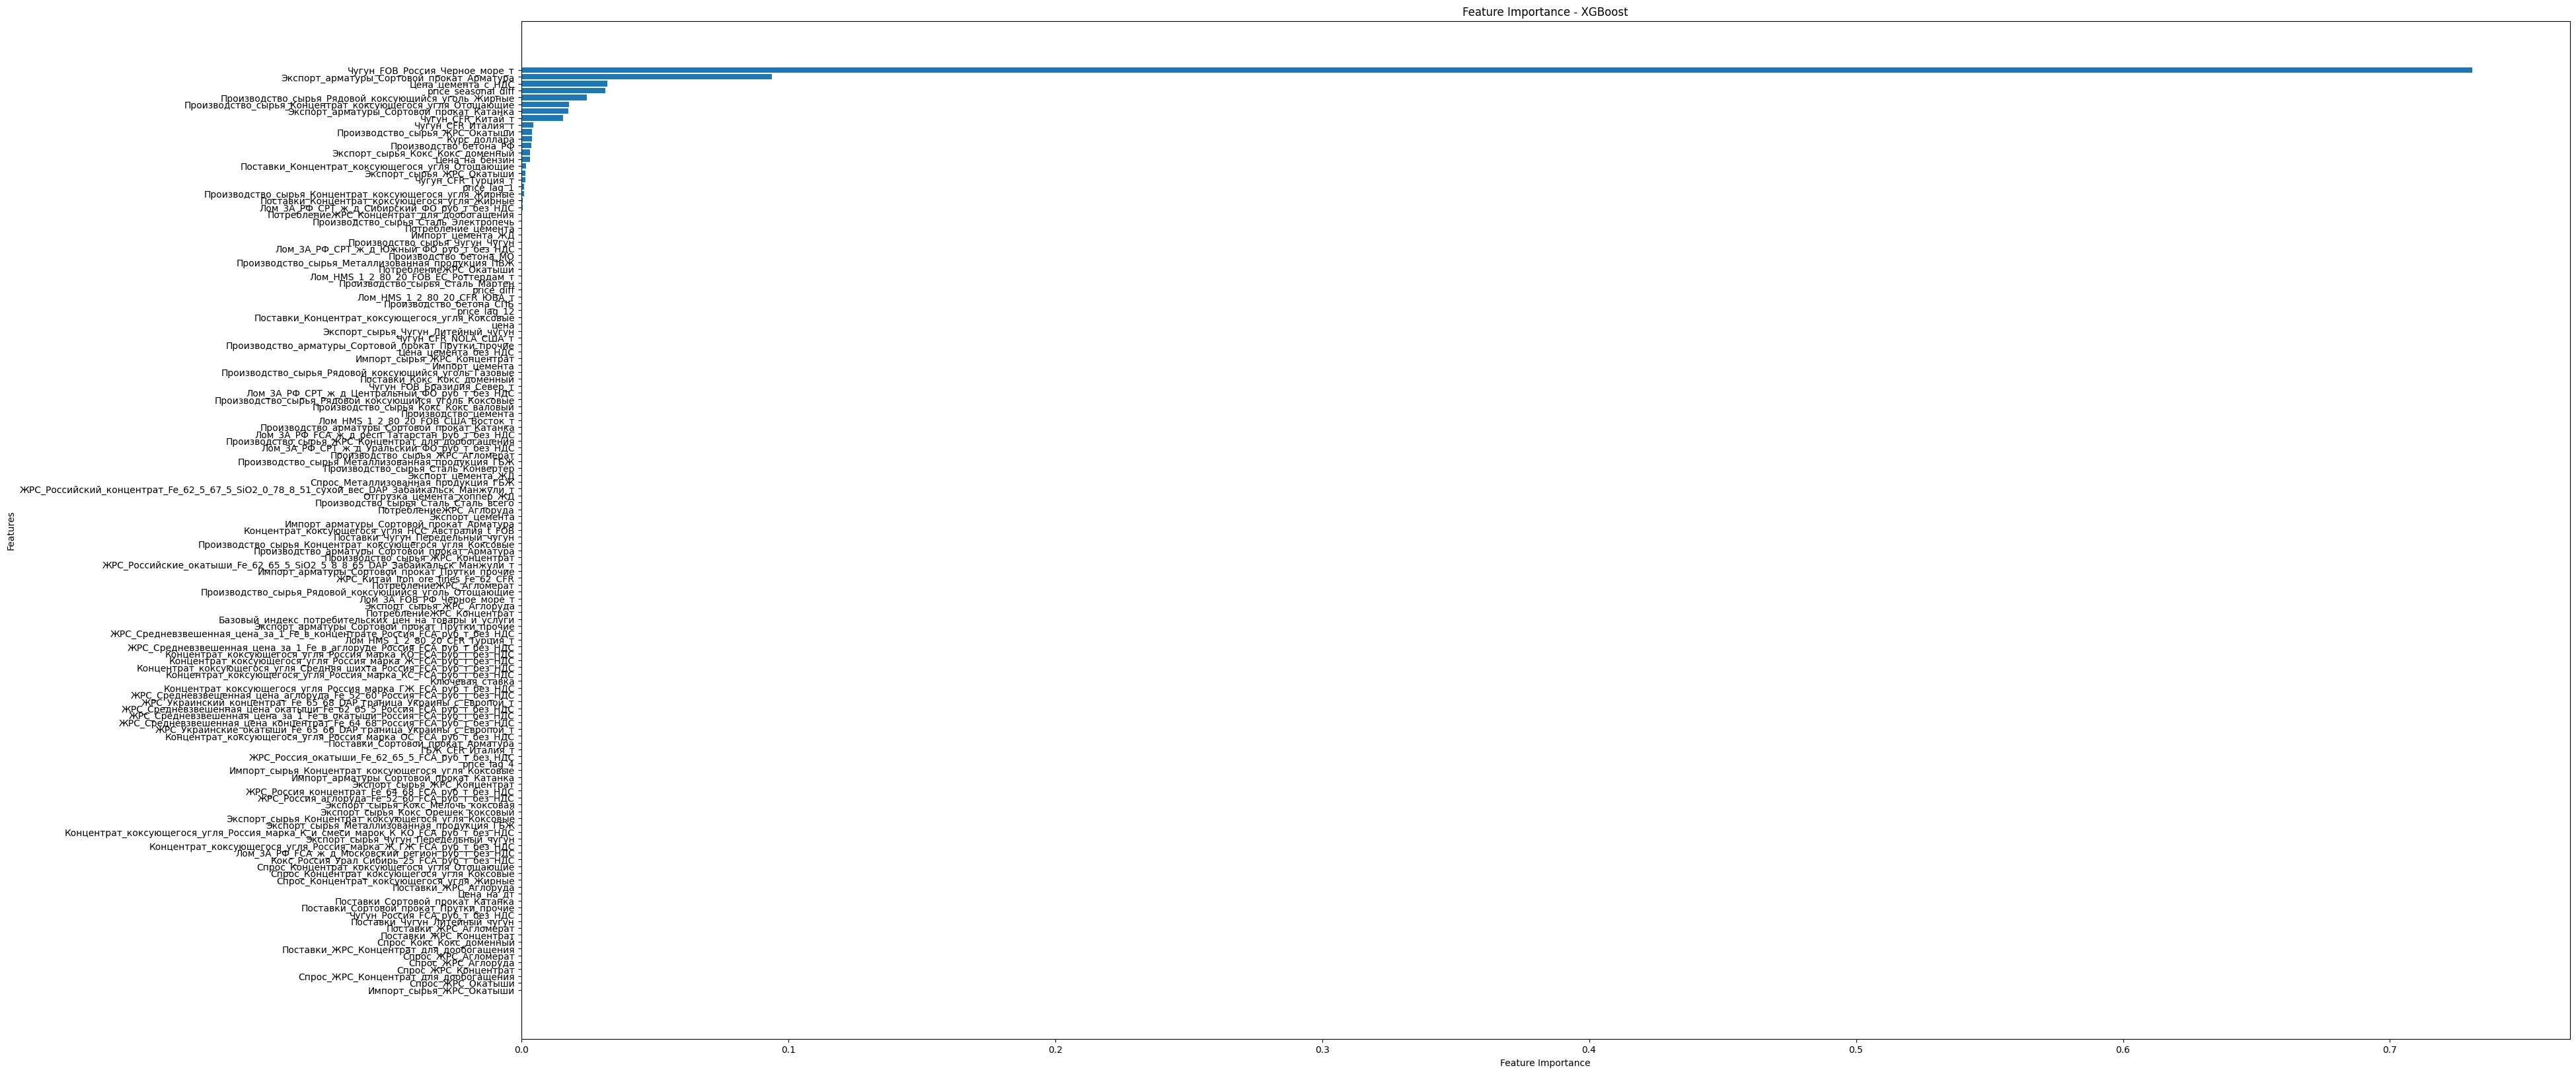

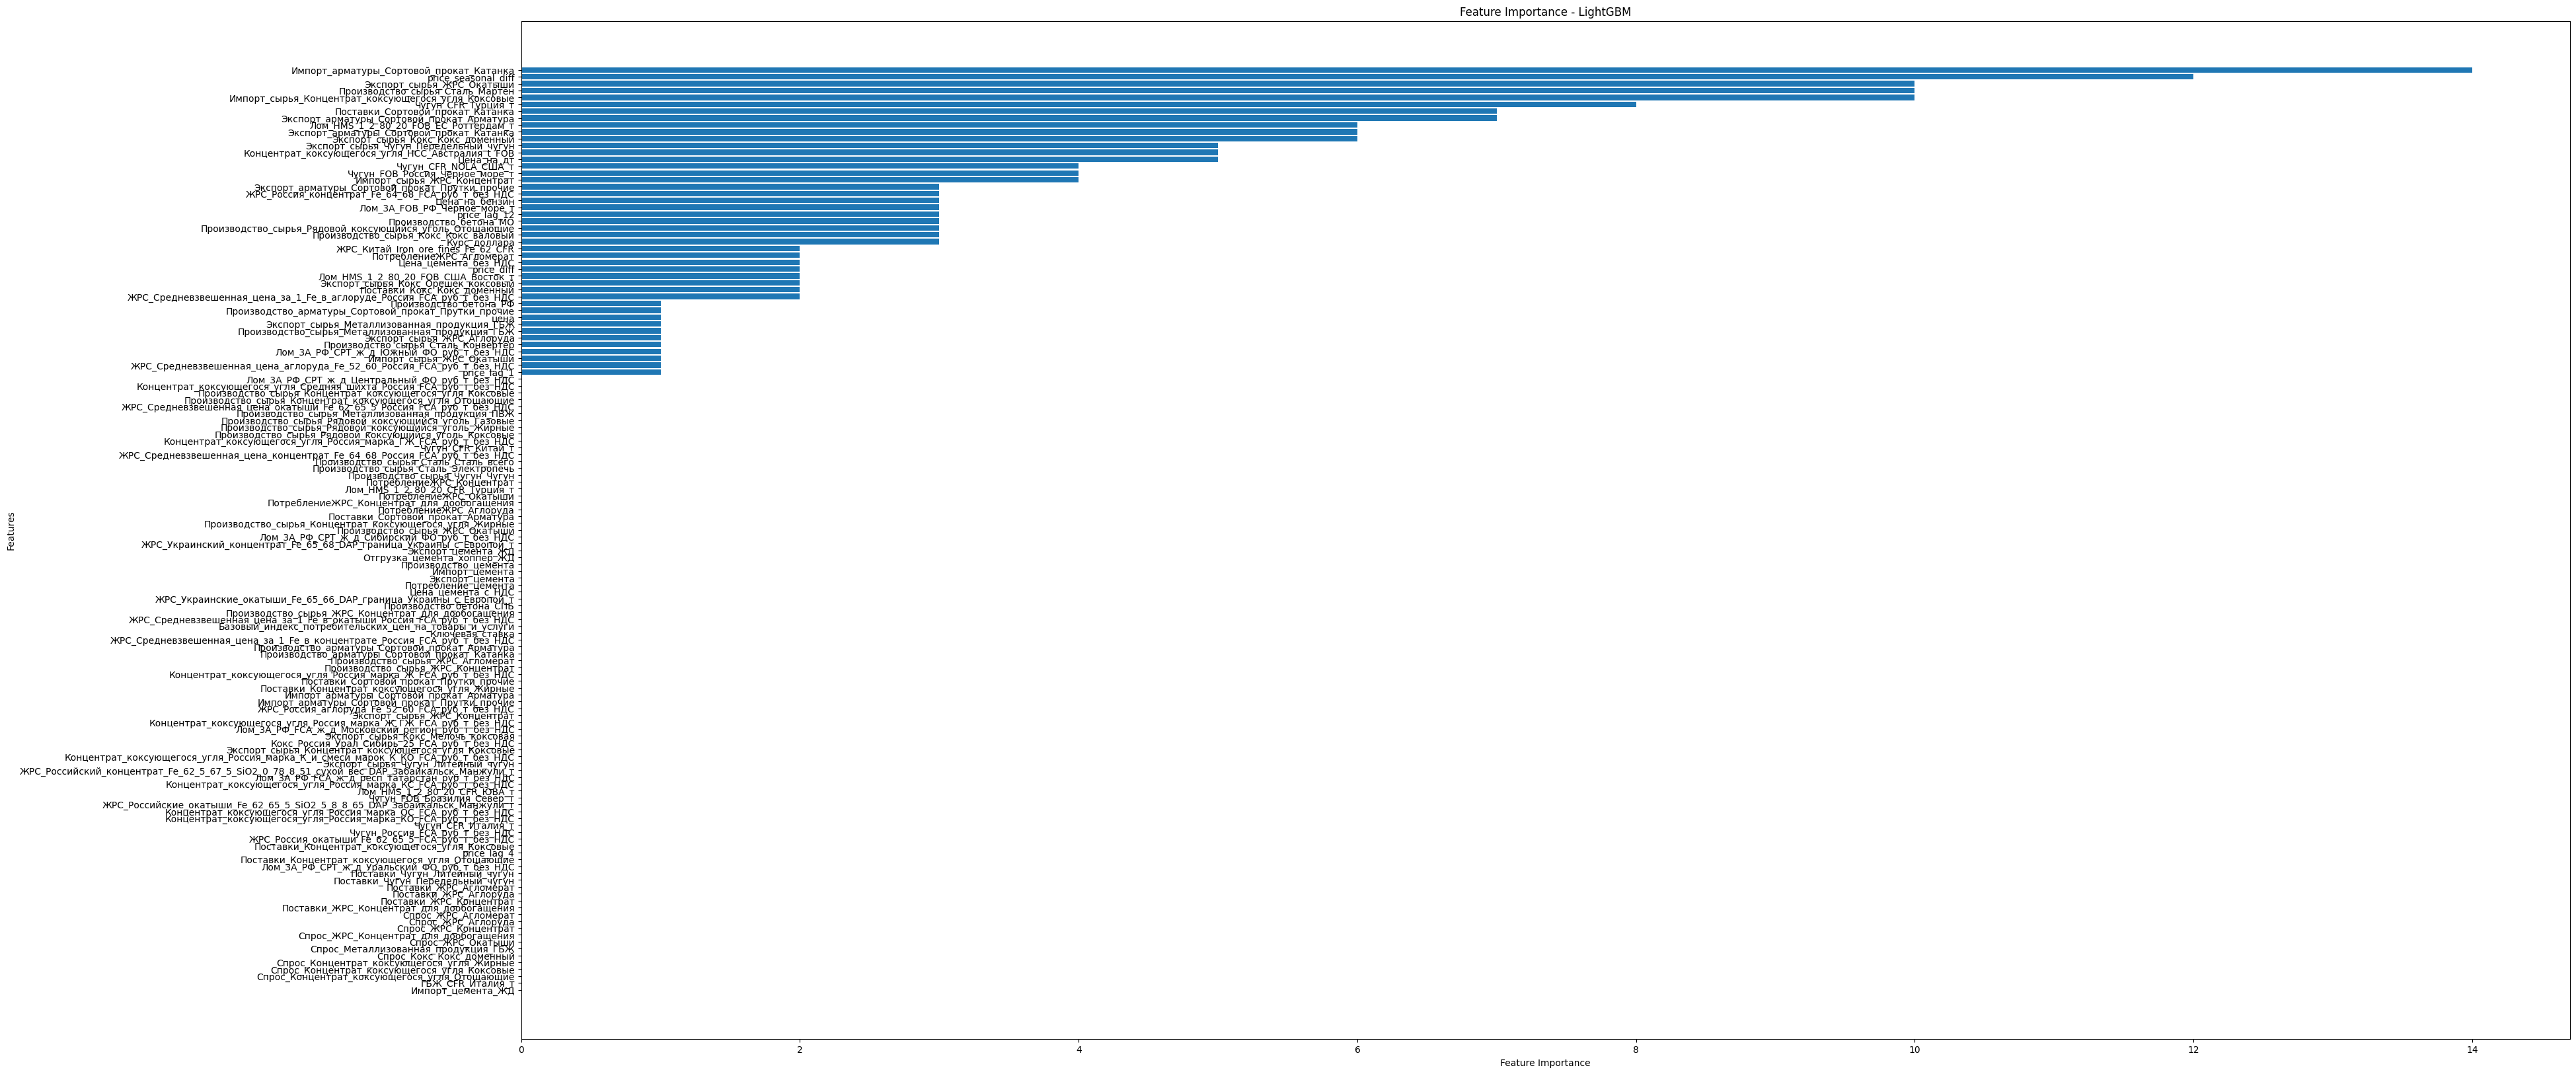

Удалено 42 признаков, оставлено 93 признаков.


In [940]:
def get_feature_importance_df(model, feature_names, model_name):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)

    plt.figure(figsize=(40, 20))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance - {model_name}")
    plt.show()
    return pd.DataFrame({'Feature': feature_names, f'{model_name}_Importance': importance})

xgb_importance = get_feature_importance_df(xgb_model, X_train.columns, "XGBoost")
lgb_importance = get_feature_importance_df(lgb_model, X_train.columns, "LightGBM")

importance_df = pd.merge(lgb_importance, xgb_importance, on='Feature', how='outer').fillna(0)

# Добавляем среднюю важность
importance_df['Average_Importance'] = (importance_df['LightGBM_Importance'] + importance_df['XGBoost_Importance']) / 2

# Фильтрация: признаки с нулевой важностью в обеих моделях
zero_importance = importance_df[(importance_df['LightGBM_Importance'] == 0) & 
                                (importance_df['XGBoost_Importance'] == 0)]

# Удаление нулевых признаков из тренировочных и тестовых данных
X_train_filtered = X_train.drop(columns=zero_importance['Feature'].values)
X_test_filtered = X_test.drop(columns=zero_importance['Feature'].values)

print(f"Удалено {len(zero_importance)} признаков, оставлено {X_train_filtered.shape[1]} признаков.")

In [941]:
stacking_model.fit(X_train_filtered, y_train)
y_pred = stacking_model.predict(X_test_filtered)

print('-----------------------------------------------------------------------------------------------------------------------------------------')
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')


print('-----------------------------------------------------------------------------------------------------------------------------------------')
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 93
[LightGBM] [Info] Start training from score 58993.333333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain